In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lit
import re
from collections import Counter


# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

In [15]:
sdf = spark.read.parquet("../data/curated/finaldf.parquet/")
sdf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2022-07-13,49891706470,22131,6731,58911,25.782245737474312,90498b80-984f-43c...,WA,Male,Non Vestibulum In...,tent and awning s...,5.80,a,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2021-08-19,96680767841,22131,6731,58911,415.9547984625,829843bc-c571-493...,WA,Male,Ornare Limited,motor vehicle sup...,5.91,a,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2022-07-13,43186523025,22131,6731,58911,33.082322196774484,c12d2520-12c8-40f...,WA,Male,Lorem Ipsum Sodal...,florists supplies...,4.47,b,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2021-08-19,66370248931,22131,6731,58911,82.54046571771035,cc8ac5c5-0dfc-4e1...,WA,Male,Morbi Non PC,"cable, satellite,...",3.15,b,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1
2022-05-06,89726005175,22131,6731,58911,58.46693553052902,b1f179f8-2c15-4f5...,WA,Male,Est Nunc Consulting,tent and awning s...,6.01,a,8374,1373,1185,2200,2600,1016,2907,39,48034,56306,0.1,0.1


Get all unique tags

In [16]:
tags = sdf.select("tags").distinct()
print(tags.count())
tags

25


tags
"opticians, optica..."
"watch, clock, and..."
computer programm...
digital goods: bo...
"books, periodical..."
florists supplies...
art dealers and g...
antique shops - s...
"gift, card, novel..."
"equipment, tool, ..."


Have 25 unique tags

Assign tags to categories as follows:

**Hobbies: books, movies, music, and games**
- artist supply and craft shops
- books, periodicals, and newspapers
- digital goods: books, movies, music
- hobby, toy and game shops
- music shops - musical instruments, pianos, and sheet music

**Home and Office**
- cable, satellite, and other pay television and radio services
- computer programming , data processing, and integrated systems design services
- computers, computer peripheral equipment, and software
- equipment, tool, furniture, and appliance rent al and leasing
- furniture, home furnishings and equipment shops, and manufacturers, except appliances
- stationery, office supplies and printing and writing paper
- telecom

**Outdoors**
- bicycle shops - sales and service
- florists supplies, nursery stock, and flowers
- lawn and garden supply outlets, including nurseries
- motor vehicle supplies and new parts
- tent and awning shops

**Self-care and Fashion**
- health and beauty spas
- jewelry, watch, clock, and silverware shops
- opticians, optical goods, and eyeglasses
- shoe shops
- watch, clock, and jewelry repair shops

**Other**
- antique shops - sales, repairs, and restoration services
- art dealers and galleries
- gift, card, novelty, and souvenir shops

In [17]:
# store first word of every tag (know that each tag begins with a unique word)
segments_dic = {
    "Hobbies": ["artist", "books", "digital", "hobby", "music"],
    "Home and Office": ["cable", "computer", "computers", "equipment", "furniture", "stationery", "telecom"],
    "Outdoor": ["bicycle", "florists", "lawn", "motor", "tent"],
    "Self-care and Fashion": ["health", "jewelry", "opticians", "shoe", "watch"],
    "Other": ["antique", "art", "gift"]
}

In [18]:
merchants_sdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
print(merchants_sdf.count())
merchants_sdf.limit(5)

4026


company_name,tags,merchant_abn,take_rate,revenue_band
Felis Limited,"furniture, home f...",10023283211,0.18,e
Arcu Ac Orci Corp...,"cable, satellite,...",10142254217,4.22,b
Nunc Sed Company,"jewelry, watch, c...",10165489824,4.40,b
Ultricies Digniss...,"watch, clock, and...",10187291046,3.29,b
Enim Condimentum PC,music shops - mus...,10192359162,6.33,a


Convert merchants data to a pandas dataframe since we need indexing, and assign `merchant_abn` as the index

In [19]:
merchants_df = merchants_sdf.toPandas().set_index('merchant_abn')
merchants_df["segment"] = np.nan
merchants_df

,company_name,tags,take_rate,revenue_band,segment
merchant_abn,,,,,
10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",0.18,e,NaN
10142254217,Arcu Ac Orci Corporation,"cable, satellite, and other pay television and...",4.22,b,NaN
10165489824,Nunc Sed Company,"jewelry, watch, clock, and silverware shops",4.40,b,NaN
10187291046,Ultricies Dignissim Lacus Foundation,"watch, clock, and jewelry repair shops",3.29,b,NaN
10192359162,Enim Condimentum PC,"music shops - musical instruments, pianos, and...",6.33,a,NaN
...,...,...,...,...,...
99938978285,Elit Dictum Eu Ltd,"opticians, optical goods, and eyeglasses",4.50,b,NaN
99974311662,Mollis LLP,"books, periodicals, and newspapers",3.17,b,NaN
99976658299,Sociosqu Corp.,shoe shops,6.57,a,NaN


Assign each merchant to a segment

In [20]:
for abn in merchants_df.index:
    tag = merchants_df._get_value(abn, "tags")
    first_word = tag.split(' ', 1)[0]
    first_word = re.sub(r'[^\w\s]', '', first_word)

    merch_segment = np.nan
    for segment, tags in segments_dic.items():
        if (first_word in tags):
            merch_segment = segment
    
    merchants_df.loc[abn, "segment"] = merch_segment

merchants_df

,company_name,tags,take_rate,revenue_band,segment
merchant_abn,,,,,
10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",0.18,e,Home and Office
10142254217,Arcu Ac Orci Corporation,"cable, satellite, and other pay television and...",4.22,b,Home and Office
10165489824,Nunc Sed Company,"jewelry, watch, clock, and silverware shops",4.40,b,Self-care and Fashion
10187291046,Ultricies Dignissim Lacus Foundation,"watch, clock, and jewelry repair shops",3.29,b,Self-care and Fashion
10192359162,Enim Condimentum PC,"music shops - musical instruments, pianos, and...",6.33,a,Hobbies
...,...,...,...,...,...
99938978285,Elit Dictum Eu Ltd,"opticians, optical goods, and eyeglasses",4.50,b,Self-care and Fashion
99974311662,Mollis LLP,"books, periodicals, and newspapers",3.17,b,Hobbies
99976658299,Sociosqu Corp.,shoe shops,6.57,a,Self-care and Fashion


Get numbered index

In [21]:
merchants_df.reset_index(drop=False,inplace=True)
merchants_df

,merchant_abn,company_name,tags,take_rate,revenue_band,segment
0,10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",0.18,e,Home and Office
1,10142254217,Arcu Ac Orci Corporation,"cable, satellite, and other pay television and...",4.22,b,Home and Office
2,10165489824,Nunc Sed Company,"jewelry, watch, clock, and silverware shops",4.40,b,Self-care and Fashion
3,10187291046,Ultricies Dignissim Lacus Foundation,"watch, clock, and jewelry repair shops",3.29,b,Self-care and Fashion
4,10192359162,Enim Condimentum PC,"music shops - musical instruments, pianos, and...",6.33,a,Hobbies
...,...,...,...,...,...,...
4021,99938978285,Elit Dictum Eu Ltd,"opticians, optical goods, and eyeglasses",4.50,b,Self-care and Fashion
4022,99974311662,Mollis LLP,"books, periodicals, and newspapers",3.17,b,Hobbies
4023,99976658299,Sociosqu Corp.,shoe shops,6.57,a,Self-care and Fashion
4024,99987905597,Commodo Hendrerit LLC,motor vehicle supplies and new parts,6.82,a,Outdoor


Convert to spark dataframe

In [22]:
merchants_sdf = spark.createDataFrame(merchants_df)
merchants_sdf.limit(5)

merchant_abn,company_name,tags,take_rate,revenue_band,segment
10023283211,Felis Limited,"furniture, home f...",0.18,e,Home and Office
10142254217,Arcu Ac Orci Corp...,"cable, satellite,...",4.22,b,Home and Office
10165489824,Nunc Sed Company,"jewelry, watch, c...",4.40,b,Self-care and Fas...
10187291046,Ultricies Digniss...,"watch, clock, and...",3.29,b,Self-care and Fas...
10192359162,Enim Condimentum PC,music shops - mus...,6.33,a,Hobbies


In [23]:
merch_points_sdf = spark.read.parquet("../data/curated/merch_points.parquet/")
merch_points_sdf.limit(5)

merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
88215945141,29647.25,0.125,12748.125,26425.875,4268.375
88218638184,13909.125,0.125,5755.875,12403.5,2023.125
88230622213,34382.125,0.125,14551.125,30820.875,4813.375
88249446460,36846.125,0.125,16337.25,32671.5,5431.25
88253903277,6010.875,0.125,2567.625,5052.0,1161.0


Join merchants and rankings obtained from notebook 5

In [24]:
print(merch_points_sdf.count())
merch_points2_sdf = merchants_sdf.join(merch_points_sdf, "merchant_abn")
print(merch_points2_sdf.count())
merch_points2_sdf.limit(5)

4018
4018


merchant_abn,company_name,tags,take_rate,revenue_band,segment,total_points,pop_points,trans_points,profit_points,mcust_points
10023283211,Felis Limited,"furniture, home f...",0.18,e,Home and Office,23850.625,0.0,14679.75,19261.0,4941.375
10142254217,Arcu Ac Orci Corp...,"cable, satellite,...",4.22,b,Home and Office,28458.25,0.0,14445.0,24405.625,4820.25
10165489824,Nunc Sed Company,"jewelry, watch, c...",4.40,b,Self-care and Fas...,3754.5,0.125,183.0,3918.0,86.25
10187291046,Ultricies Digniss...,"watch, clock, and...",3.29,b,Self-care and Fas...,15534.75,0.125,8434.5,13181.25,2719.5
10192359162,Enim Condimentum PC,music shops - mus...,6.33,a,Hobbies,23528.5,0.125,8806.875,21416.25,3081.25


In [25]:
w = Window.partitionBy(merch_points2_sdf['segment']).orderBy(merch_points2_sdf['total_points'].desc())

seg_ranks_sdf = merch_points2_sdf \
    .select('*', rank().over(w).alias('rank')) \
    .filter(col('rank') <= 10)

print(seg_ranks_sdf.count())
print(seg_ranks_sdf.limit(20))

50
+------------+--------------------+--------------------+---------+------------+---------------+------------+----------+------------+-------------+------------+----+
|merchant_abn|        company_name|                tags|take_rate|revenue_band|        segment|total_points|pop_points|trans_points|profit_points|mcust_points|rank|
+------------+--------------------+--------------------+---------+------------+---------------+------------+----------+------------+-------------+------------+----+
| 64403598239|Lobortis Ultrices...|music shops - mus...|     6.31|           a|        Hobbies|    42080.25|     0.125|     18022.5|    37576.875|      6007.5|   1|
| 72472909171|   Nullam Consulting|digital goods: bo...|     6.33|           a|        Hobbies|   42032.125|       0.0|     18018.0|      37526.5|      6006.0|   2|
| 98973094975|   Ornare Fusce Inc.|hobby, toy and ga...|     5.98|           a|        Hobbies|     41918.5|       0.0|   17950.875|      37432.0|      5985.0|   3|
| 63290

Have obtained the top 10 merchants for each segment

***

Visualize the frequency of each tag for each segment

{'music shops - musical instruments, pianos, and sheet music': 2, 'digital goods: books, movies, music': 4, 'hobby, toy and game shops': 1, 'artist supply and craft shops': 1, 'books, periodicals, and newspapers': 2}
{'cable, satellite, and other pay television and radio services': 1, 'furniture, home furnishings and equipment shops, and manufacturers, except appliances': 3, 'computer programming , data processing, and integrated systems design services': 3, 'computers, computer peripheral equipment, and software': 3}
{'tent and awning shops': 3, 'florists supplies, nursery stock, and flowers': 5, 'motor vehicle supplies and new parts': 1, 'lawn and garden supply outlets, including nurseries': 1}
{'watch, clock, and jewelry repair shops': 6, 'opticians, optical goods, and eyeglasses': 2, 'shoe shops': 2}
{'gift, card, novelty, and souvenir shops': 8, 'antique shops - sales, repairs, and restoration services': 2}


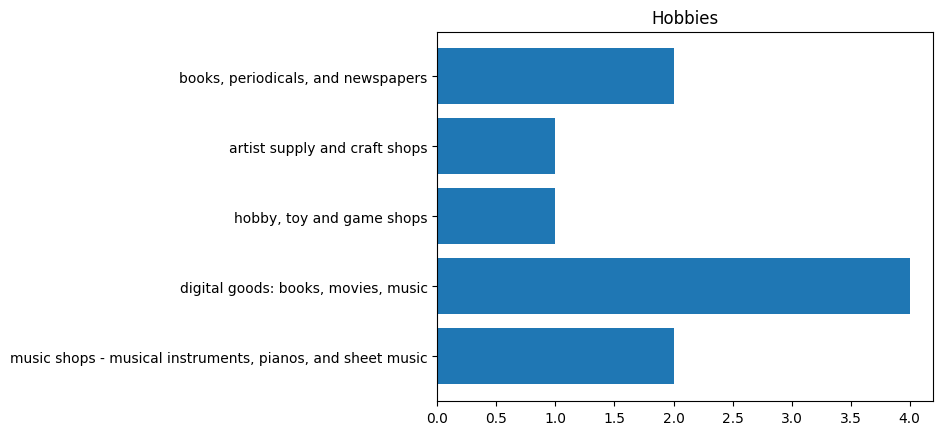

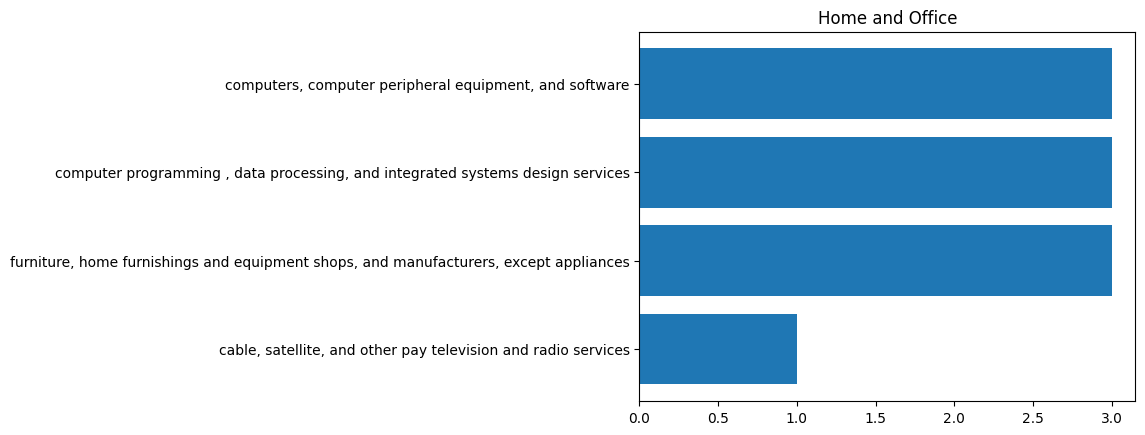

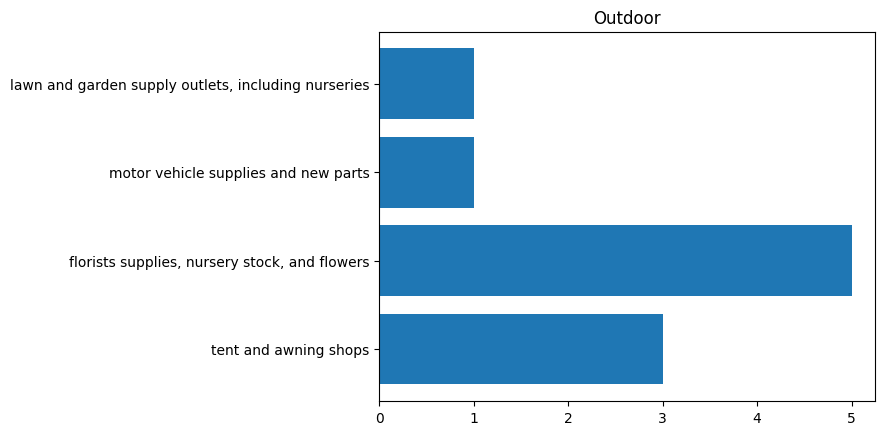

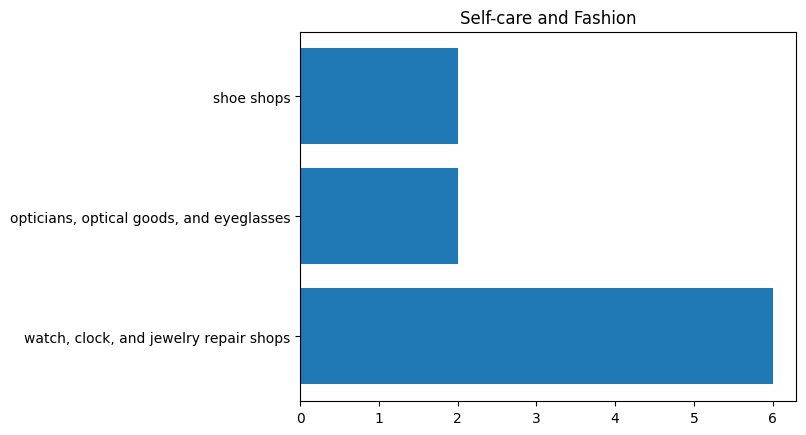

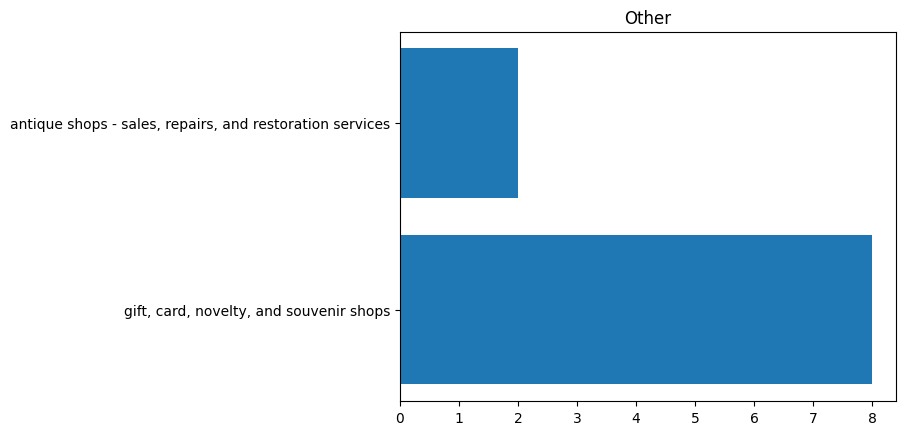

In [26]:
seg_ranks_df = seg_ranks_sdf.toPandas()
seg_ranks_grp = seg_ranks_df.groupby(["segment"])

i = 0
for segment in segments_dic.keys():
    top10 = seg_ranks_grp.get_group(segment)
    tags_count = dict(Counter(top10["tags"]))
    print(tags_count)

    plt.figure(i)
    plt.title(segment)
    plt.barh(list(tags_count.keys()), list(tags_count.values()))

    i += 1
